In [1]:
import warnings
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

RANDOM_SEED = 6324
np.random.seed(RANDOM_SEED)
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

### Data processing

In [64]:
df = pd.read_csv('nasdaq_big.csv')
y = df['y'].to_numpy()
x = df[['x1','x2','x3','x4','x5']].to_numpy()
t = np.arange(len(y))

In [65]:
# Split
i = int(len(y)*0.8)
y_train = y[:i]
y_test = y[i:]
x_train = x[:i]
x_test = x[i:]
t_train = t[:i]
t_test = t[i:]

### Random Forest

In [45]:
def rfr_evaluate(max_depth, min_samples_leaf, min_samples_split, n_estimators):
    rfr = RandomForestRegressor(max_depth=int(max_depth),
                                min_samples_leaf=int(min_samples_leaf),
                                min_samples_split=int(min_samples_split),
                                n_estimators=int(n_estimators))
    rfr.fit(x_train,y_train)
    train_pred = rfr.predict(x_train)
    return -1.0 * np.sqrt(mean_squared_error(y_train, train_pred))

In [46]:
rfr_bo = BayesianOptimization(rfr_evaluate, {'max_depth': (3, 10), 
                                             'min_samples_leaf': (1, 4),
                                             'min_samples_split': (2, 10),
                                             'n_estimators': (100, 200)})
rfr_bo.maximize(init_points=5, n_iter=10, acq='ei')

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        | -90.12    |  4.797    |  3.829    |  9.732    |  139.4    |
|  2        | -56.0     |  5.388    |  1.327    |  7.551    |  153.0    |
|  3        | -34.92    |  9.758    |  2.811    |  7.949    |  186.6    |
|  4        | -55.73    |  5.28     |  1.14     |  5.408    |  189.1    |
|  5        | -37.79    |  8.598    |  2.832    |  6.366    |  149.4    |
|  6        | -89.85    |  4.758    |  2.669    |  5.841    |  167.6    |
|  7        | -39.35    |  10.0     |  4.0      |  10.0     |  187.5    |
|  8        | -38.17    |  10.0     |  4.0      |  8.262    |  183.3    |
|  9        | -36.14    |  9.051    |  3.598    |  2.267    |  149.7    |
|  10       | -27.57    |  10.0     |  1.0      |  3.522    |  148.7    |
|  11       | -26.66    |  10.0     |  1.0      |  2.0      |  100.0    |
|  12       | -89.84    |  4.358    | 

In [47]:
paramsop = rfr_bo.max['params']
paramsop['max_depth'] = int(paramsop['max_depth'])

In [48]:
paramsop

{'max_depth': 10,
 'min_samples_leaf': 1.0,
 'min_samples_split': 2.0,
 'n_estimators': 100.0}

In [49]:
# Train a new model with the best parameters from the search
model1 = RandomForestRegressor(max_depth=int(paramsop['max_depth']),
                               min_samples_leaf=int(paramsop['min_samples_leaf']),
                               min_samples_split=int(paramsop['min_samples_split']),
                               n_estimators=int(paramsop['n_estimators']))
model1.fit(x_train,y_train)

y_pred = model1.predict(x_test)

print(np.sqrt(mean_squared_error(y_test, y_pred)))

3107.0658705624846


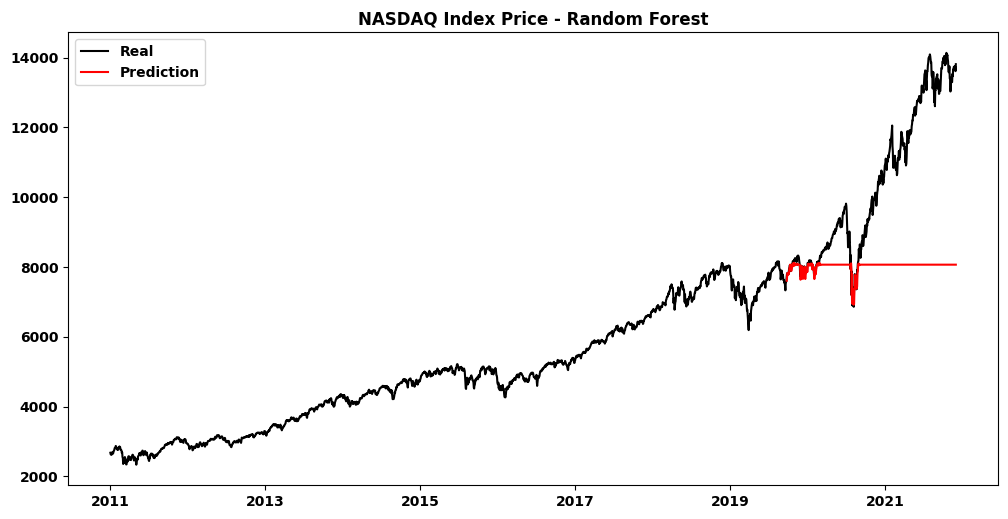

In [52]:
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black"}

plt.rcParams.update(params)

plt.title("NASDAQ Index Price - Random Forest")

plt.plot(df.index,
         y,
         color='black',
         label="Real")

plt.plot(t_test,
         y_pred,
         label="Prediction",
         color="red")

locs, labels = plt.xticks()
plt.xticks([0,460,920,1380,1840,2300],['2011','2013','2015','2017','2019','2021'])
plt.legend(loc=2)

### XGBoost

In [66]:
dtrain = xgb.DMatrix(x_train, label=y_train)
del(x_train)
dtest = xgb.DMatrix(x_test)
del(x_test)

In [77]:
def xgb_evaluate(max_depth, gamma, colsample_bytree):
    params = {'eval_metric': 'rmse',
              'max_depth': int(max_depth),
              'gamma': gamma,
              'colsample_bytree': colsample_bytree,
              'subsample': 0.8,
              'eta': 0.1}
    cv_result = xgb.cv(params, d_test, num_boost_round=100, nfold=3)
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [78]:
xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (3, 7), 
                                             'gamma': (0, 1),
                                             'colsample_bytree': (0.1, 0.9)})
xgb_bo.maximize(init_points=10, n_iter=40, acq='ei')

|   iter    |  target   | colsam... |   gamma   | max_depth |
-------------------------------------------------------------
|  1        | -194.8    |  0.5781   |  0.1313   |  3.886    |
|  2        | -196.5    |  0.5481   |  0.3416   |  5.664    |
|  3        | -240.6    |  0.2154   |  0.3212   |  6.526    |
|  4        | -186.5    |  0.7398   |  0.5082   |  6.05     |
|  5        | -198.6    |  0.5766   |  0.09303  |  6.774    |
|  6        | -195.4    |  0.504    |  0.9914   |  4.391    |
|  7        | -185.0    |  0.6562   |  0.894    |  3.251    |
|  8        | -185.0    |  0.6181   |  0.003455 |  3.528    |
|  9        | -231.3    |  0.296    |  0.9377   |  3.092    |
|  10       | -186.3    |  0.6726   |  0.1673   |  4.643    |
|  11       | -185.0    |  0.7873   |  0.6665   |  3.893    |
|  12       | -194.8    |  0.4139   |  0.1567   |  3.484    |
|  13       | -194.8    |  0.5618   |  0.05958  |  3.568    |
|  14       | -238.3    |  0.2154   |  0.5458   |  5.613    |
|  15   

In [79]:
paramsop = xgb_bo.max['params']
paramsop['max_depth'] = int(paramsop['max_depth'])

In [80]:
paramsop

{'colsample_bytree': 0.8441619227169794, 'gamma': 0.0, 'max_depth': 3}

In [81]:
# Train a new model with the best parameters from the search
model2 = xgb.train(paramsop, dtrain, num_boost_round=250)

# Predict on testing and training set
y_pred = model2.predict(dtest)

# Report testing and training RMSE
print(np.sqrt(mean_squared_error(y_test, y_pred)))

3100.707221057409


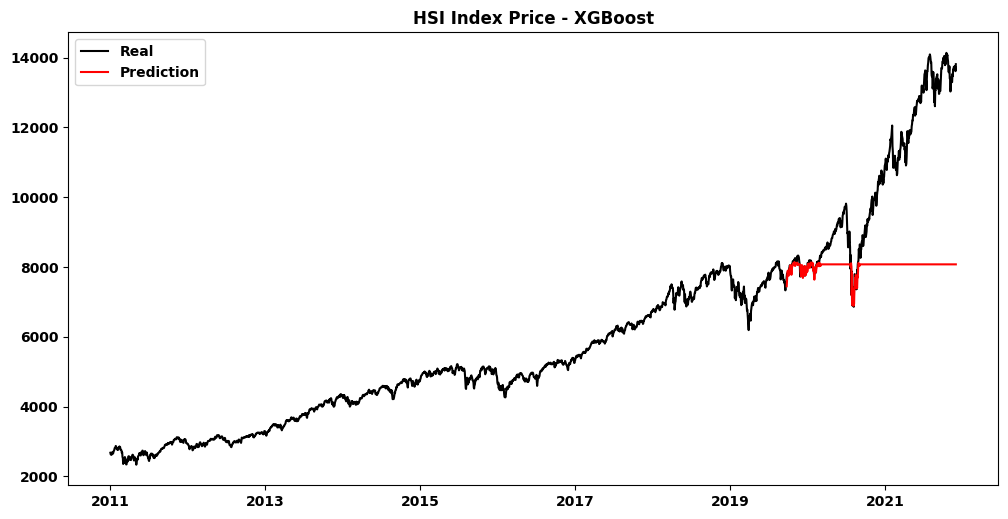

In [82]:
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black"}

plt.rcParams.update(params)

plt.title("HSI Index Price - XGBoost")

plt.plot(df.index,
         y,
         color='black',
         label="Real")

plt.plot(t_test,
         y_pred,
         label="Prediction",
         color="red")

locs, labels = plt.xticks()
plt.xticks([0,460,920,1380,1840,2300],['2011','2013','2015','2017','2019','2021'])

plt.legend(loc=2)